# Step 1: Install Libraries


In [ ]:
!pip install lightgbm pandas numpy matplotlib scikit-learn --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load Dataset

In [ ]:
file_path = '/content/tourism_with_temps.xlsx'
df = pd.read_excel(file_path)
df.head()


,month,year,destinationProvinceNameEn,originProvinceNameEn,visitPurposeEn,trips,spendSAR,nights,origin_temp,destination_temp
0,1,2018,Albaha,Alqassim,Leisure,1754.46,2631692.38,5263.38,12.08,19.0
1,1,2018,Albaha,Jazan,VFR,1583.60,2375406.99,4750.81,26.09,19.0
2,1,2018,Albaha,Madinah,Leisure,12733.95,20629002.13,72159.06,14.67,19.0
3,1,2018,Albaha,Makkah,Business,6568.35,5327660.65,15326.15,20.71,19.0
4,1,2018,Albaha,Makkah,Leisure,68910.76,44778264.67,390646.05,20.71,19.0


##Dataset Columns Explanation

1. month
رقم الشهر من 1 إلى 12.
يساعد في فهم التغيرات الموسمية، حيث يختلف عدد الزوار من شهر لآخر.

2. year
السنة (مثل 2018، 2019...).
يُستخدم لتقسيم البيانات إلى تدريب واختبار، مثل التدريب على 2018–2022 والاختبار على 2023.

3. destinationProvinceNameEn
اسم الوجهة السياحية (المدينة أو المنطقة التي تم السفر إليها).
مهم لأن كل مدينة لها ظروف مختلفة مثل الطقس والفعاليات.

4. originProvinceNameEn
اسم المنطقة الأصلية (من أين جاء الزوار).
يساعد على تحليل أنماط السفر بين المناطق.

5. visitPurposeEn
الغرض من الزيارة، مثل:

Leisure = سياحة أو ترفيه

VFR = زيارة أصدقاء أو عائلة

Business = عمل
الغرض من الزيارة يؤثر على عدد الرحلات وسلوك الزوار.

6. trips
عدد الرحلات السياحية من المنطقة الأصلية إلى الوجهة في ذلك الشهر.
هذا العمود غالباً سيكون المتغير الهدف (Target) في نموذج التنبؤ.

7. spendSAR
إجمالي الإنفاق بالريال السعودي للرحلات في ذلك الشهر.
يمكن استخدامه كميزة إضافية أو تحليله لاحقاً.

8. nights
إجمالي عدد الليالي التي قضاها الزوار في الوجهة.
يعطي مؤشراً على مدة الإقامة السياحية.

9. origin_temp
متوسط درجة الحرارة في المنطقة الأصلية خلال ذلك الشهر.
الطقس في المنطقة الأصلية قد يؤثر على قرارات السفر.

10. destination_temp
متوسط درجة الحرارة في الوجهة السياحية خلال ذلك الشهر.
عامل مهم في السياحة، خاصة في السعودية حيث الطقس يؤثر بشكل واضح على حركة الزوار.

# Normalize Column Names

In [ ]:
# توحيد أسماء الأعمدة
import re
def to_snake(cols):
    fixed = []
    for c in cols:
        c2 = re.sub(r'(?<=[a-z0-9])([A-Z])', r'_\1', c)
        c2 = re.sub(r'[^A-Za-z0-9_]+', '_', c2)
        c2 = re.sub(r'__+', '_', c2).strip('_').lower()
        fixed.append(c2)
    return fixed

df.columns = to_snake(df.columns)
print(df.columns.tolist())

['month', 'year', 'destination_province_name_en', 'origin_province_name_en', 'visit_purpose_en', 'trips', 'spend_sar', 'nights', 'origin_temp', 'destination_temp']


# Quick Data Inspection

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30850 entries, 0 to 30849
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   month                         30850 non-null  int64  
 1   year                          30850 non-null  int64  
 2   destination_province_name_en  30850 non-null  object 
 3   origin_province_name_en       30850 non-null  object 
 4   visit_purpose_en              30850 non-null  object 
 5   trips                         30850 non-null  float64
 6   spend_sar                     30850 non-null  float64
 7   nights                        30850 non-null  float64
 8   origin_temp                   28263 non-null  float64
 9   destination_temp              28021 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 2.4+ MB


In [ ]:
df.head()

,month,year,destination_province_name_en,origin_province_name_en,visit_purpose_en,trips,spend_sar,nights,origin_temp,destination_temp
0,1,2018,Albaha,Alqassim,Leisure,1754.46,2631692.38,5263.38,12.08,19.0
1,1,2018,Albaha,Jazan,VFR,1583.60,2375406.99,4750.81,26.09,19.0
2,1,2018,Albaha,Madinah,Leisure,12733.95,20629002.13,72159.06,14.67,19.0
3,1,2018,Albaha,Makkah,Business,6568.35,5327660.65,15326.15,20.71,19.0
4,1,2018,Albaha,Makkah,Leisure,68910.76,44778264.67,390646.05,20.71,19.0


In [ ]:
df.isnull().sum()#يفحص عدد القيم المفقودة (NaN) في كل عمود من أعمدة الداتا.

,0
month,0
year,0
destination_province_name_en,0
origin_province_name_en,0
visit_purpose_en,0
trips,0
spend_sar,0
nights,0
origin_temp,2587
destination_temp,2829


# Data Cleaning
ملاحظات:
- في هذا القسم أنظف البيانات وأجهزها للـ Feature Engineering.
- أقسم التنظيف إلى قسمين:
  1. تنظيف الأعمدة النصية: إزالة الفراغات والتأكد من القيم الفريدة.
  2. معالجة القيم المفقودة والأرقام غير المنطقية للأعمدة الرقمية.
- لازم أتأكد في النهاية أن ما بقى أي NaN قبل الانتقال للمرحلة التالية.


##Text Columns Cleaning
ملاحظة:
- أركز هنا على الأعمدة النصية مثل أسماء المدن وأهداف الزيارة.
- أزيل أي فراغات زائدة (strip) عشان ما تصير القيم مكررة بشكل خفي.
- أراجع عدد القيم الفريدة بعد التنظيف للتأكد من أن التنسيق صار موحد.

In [ ]:
text_cols = ['destination_province_name_en', 'origin_province_name_en', 'visit_purpose_en']

# تنظيف النصوص
for col in text_cols:# افترض ان text_cols is col
    df[col] = df[col].astype(str).str.strip()
#astype(str) تحويل الى نص
#str.strip() يشيل الفراغ وهذي خطوة التنظيف
# عدد القيم الفريدة كفحص سريع
for col in text_cols:
    print(f"{col} - unique:", df[col].nunique()) # هنا عشان اطلع اليونيك فاليو

# معاينة
df[text_cols].head(10)


destination_province_name_en - unique: 13
origin_province_name_en - unique: 13
visit_purpose_en - unique: 5


,destination_province_name_en,origin_province_name_en,visit_purpose_en
0,Albaha,Alqassim,Leisure
1,Albaha,Jazan,VFR
2,Albaha,Madinah,Leisure
3,Albaha,Makkah,Business
4,Albaha,Makkah,Leisure
5,Albaha,Makkah,VFR
6,Albaha,Najran,Leisure
7,Albaha,Riyadh,Leisure
8,Albaha,Riyadh,VFR
9,Albaha,Tabuk,Leisure


##Numeric Columns & Missing Values
ملاحظات:
- أعالج القيم المفقودة في درجات الحرارة باستخدام متوسط (المدينة + الشهر) لكل صف.
- إذا بقت قيم ناقصة بعد التعبئة، أحذف الصفوف القليلة المتبقية.
- أتأكد من حذف القيم غير المنطقية مثل القيم السالبة في trips أو spend_sar.
- في النهاية أشيك باستخدام df.isnull().sum() للتأكد أن البيانات صارت نظيفة.

In [ ]:
# تعبئة درجات الحرارة المفقودة حسب (المدينة، الشهر)
df['origin_temp'] = df.groupby(['origin_province_name_en', 'month'])['origin_temp']\
                      .transform(lambda s: s.fillna(s.mean()))

df['destination_temp'] = df.groupby(['destination_province_name_en', 'month'])['destination_temp']\
                           .transform(lambda s: s.fillna(s.mean()))

# حذف الصفوف المتبقية الناقصة
df = df.dropna(subset=['origin_temp', 'destination_temp'])

# التحقق من القيم الرقمية غير المنطقية
num_cols = ['trips', 'spend_sar', 'nights']
for col in num_cols:
    if col in df.columns:
        df = df[df[col] >= 0]


In [ ]:
# فحص سريع بعد التنظيف
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25686 entries, 0 to 30849
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   month                         25686 non-null  int64  
 1   year                          25686 non-null  int64  
 2   destination_province_name_en  25686 non-null  object 
 3   origin_province_name_en       25686 non-null  object 
 4   visit_purpose_en              25686 non-null  object 
 5   trips                         25686 non-null  float64
 6   spend_sar                     25686 non-null  float64
 7   nights                        25686 non-null  float64
 8   origin_temp                   25686 non-null  float64
 9   destination_temp              25686 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 2.2+ MB


In [ ]:
df.isnull().sum()

,0
month,0
year,0
destination_province_name_en,0
origin_province_name_en,0
visit_purpose_en,0
trips,0
spend_sar,0
nights,0
origin_temp,0
destination_temp,0


# Feature Engineering

## ملاحظة حول Month Seasonality و Feature Engineering

- الشهر كرقم عادي (1 إلى 12) لا يوضح للمودل أن الشهور تتكرر بشكل دائري، فمثلاً شهر 12 قريب من شهر 1 زمنيًا، لكن المودل قد يظنهما بعيدين (12 - 1 = 11).  
- عشان نوضح هذا النمط للمودل، نستخدم دوال Sine و Cosine لتحويل الشهر إلى تمثيل دائري، بحيث يتمكن المودل من التقاط الأنماط الموسمية بسهولة.
- بالنسبة للميزات المشتقة مثل `temp_difference`، الهدف منها تبسيط العلاقات المهمة للمودل (مثل الفرق بين درجات الحرارة في الوجهة والمنطقة الأصلية) بدل ما يكتشفها بنفسه.  
- هذه الخطوات اختيارية لكنها غالبًا تحسن دقة التنبؤ لأنها تساعد المودل يفهم البيانات بشكل أوضح.


##تحويل القيم النصية إلى أرقام (Encoding)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_cols = ['destination_province_name_en', 'origin_province_name_en', 'visit_purpose_en'] # هذي الاعمده حروف ف لازم احولها لارقام

encoders = {}
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le  # نخزنها لو احتجناها لاحقاً


##إضافة موسمية الشهر (Month Seasonality)

In [ ]:
import numpy as np

df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)


##ميزات مشتقة إضافية (Feature Engineering Ideas)

In [ ]:
df['temp_difference'] = df['destination_temp'] - df['origin_temp']


# Train/Test Split

## ملاحظة حول Train/Test Split و X/y

- بما أن البيانات زمنية، نقسمها حسب السنوات (مثلاً ندرّب على 2018–2022 ونختبر على 2023) لضمان أن المودل يتعلم من الماضي ويتنبأ بالمستقبل.  
- **Train**: البيانات التي يتعلم منها المودل.  
- **Test**: البيانات التي نقيس بها مدى دقة المودل على بيانات جديدة.  
- **X**: أعمدة الإدخال (Features) التي نستخدمها للتنبؤ.  
- **y**: العمود الهدف (Target) الذي نريد أن يتنبأ به المودل.


In [ ]:
#Train/Test Split by Year
year_split = 2023  # نستخدم 2023 كسنة للاختبار

train = df[df['year'] < year_split].copy()
test  = df[df['year'] == year_split].copy()

target_col = 'trips'  # هذا هو المتغير الهدف اللي يتنبأ فيه المودل

# الأعمدة اللي راح نستخدمها كـ features
feature_cols = [
    'destination_province_name_en',
    'origin_province_name_en',
    'visit_purpose_en',
    'month', 'month_sin', 'month_cos',
    'origin_temp', 'destination_temp',
    'temp_difference',
    'spend_sar', 'nights'
]
feature_cols = [c for c in feature_cols if c in df.columns]

X_train, y_train = train[feature_cols], train[target_col]
X_test,  y_test  = test[feature_cols],  test[target_col]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Features used:", feature_cols)


Train shape: (19561, 11)
Test shape: (6125, 11)
Features used: ['destination_province_name_en', 'origin_province_name_en', 'visit_purpose_en', 'month', 'month_sin', 'month_cos', 'origin_temp', 'destination_temp', 'temp_difference', 'spend_sar', 'nights']


# Train LightGBM Model

## ملاحظة: نموذج LightGBM ولماذا اخترناه

- LightGBM هو نموذج من عائلة Gradient Boosting يعتمد على بناء عدة أشجار قرار بشكل متسلسل، بحيث كل شجرة تصحح أخطاء الشجرة التي قبلها.  
- هذا النوع من النماذج مناسب جدًا للبيانات الجدولية (Tabular Data) مثل بيانات المدن، الأشهر، درجات الحرارة وعدد الزوار.
- يتميز بسرعته ودقته في التعامل مع العلاقات غير الخطية والتفاعلات بين المتغيرات (مثل تأثير الشهر + الطقس + المدينة على عدد الزوار).
- أيضًا سهل تفسيره، لأننا نستطيع معرفة أي الأعمدة أثرت أكثر على التنبؤ (Feature Importance).
- في مشروعنا، الهدف هو توقع عدد الزوار بناءً على عوامل متعددة، وLightGBM مناسب لهذا النوع من المهام لأنه:
  - يتعامل جيدًا مع الميزات الفئوية بعد ترميزها.
  - يدعم الـ early stopping لتجنب المبالغة في التعلم.
  - لا يحتاج إلى تجهيز معقد للبيانات مثل الشبكات العصبية.


In [ ]:
# Train LightGBM Model
import lightgbm as lgb

#design model
model = lgb.LGBMRegressor(# Hyperparameter Tuning
     num_leaves=160,       # عدد الاوراق في كل شجره - كل ما زاد الرقم صار اعقد
    max_depth=12,         #أقصى عمق للشجرة (التحكم في التعقيد ومنع الـ overfitting)
    learning_rate=0.03,# سرعة التعلّم (كل ما كانت أقل، كان التعلّم أبطأ بس أدق غالبًا)
    n_estimators=5000,#عدد الأشجار (boosting iterations)
    subsample=0.8,#نسبة العيّنات المستخدمة في كل شجرة (يساعد على تقليل الـ overfitting)
    colsample_bytree=0.8,#نسبة الخصائص المستخدمة في كل شجرة (يساعد على التنويع)
    random_state=42#عشان نثبت العشوائية، ونحصل على نفس النتائج كل مرة
)
#Training model
model.fit(# بداية التدريب
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=200)],
)

print("Model training completed.")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1329
[LightGBM] [Info] Number of data points in the train set: 19561, number of used features: 11
[LightGBM] [Info] Start training from score 11302.622084
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

#Evaluate Model

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)# كل ماكام اقل كل ماكان افضل
rmse = np.sqrt(mean_squared_error(y_test, y_pred))# كل ماكان اقل كل ماكان افضل
r2 = r2_score(y_test, y_pred)# كل ماكان اقرب لل1 كل ماكان افضل

print(f"MAE  (Mean Absolute Error): {mae:,.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:,.2f}")
print(f"R²   (Coefficient of Determination): {r2:.3f}")


MAE  (Mean Absolute Error): 4,477.60
RMSE (Root Mean Squared Error): 15,291.30
R²   (Coefficient of Determination): 0.793


#Visualize Model Performance

##Plot Actual vs Predicted (Scatter Plot)

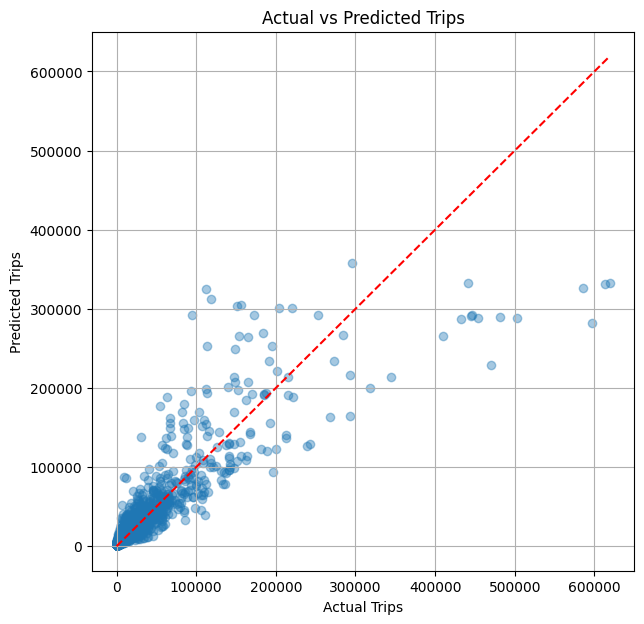

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel('Actual Trips')
plt.ylabel('Predicted Trips')
plt.title('Actual vs Predicted Trips')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # خط مثالي
plt.grid(True)
plt.show()


##Residual Plot

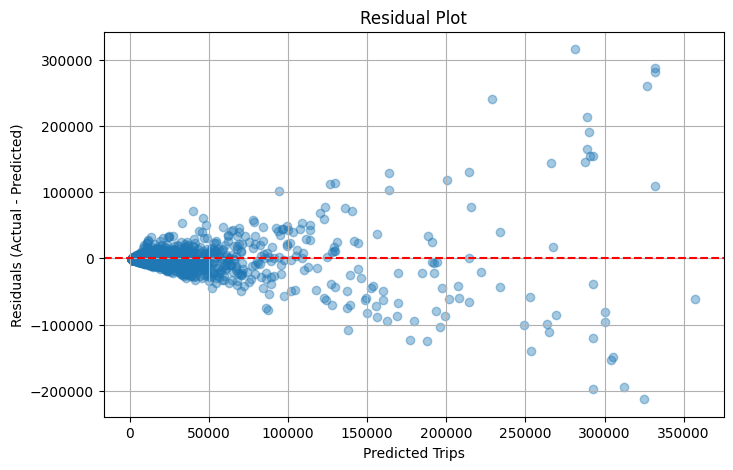

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Trips')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()


##Feature Importance

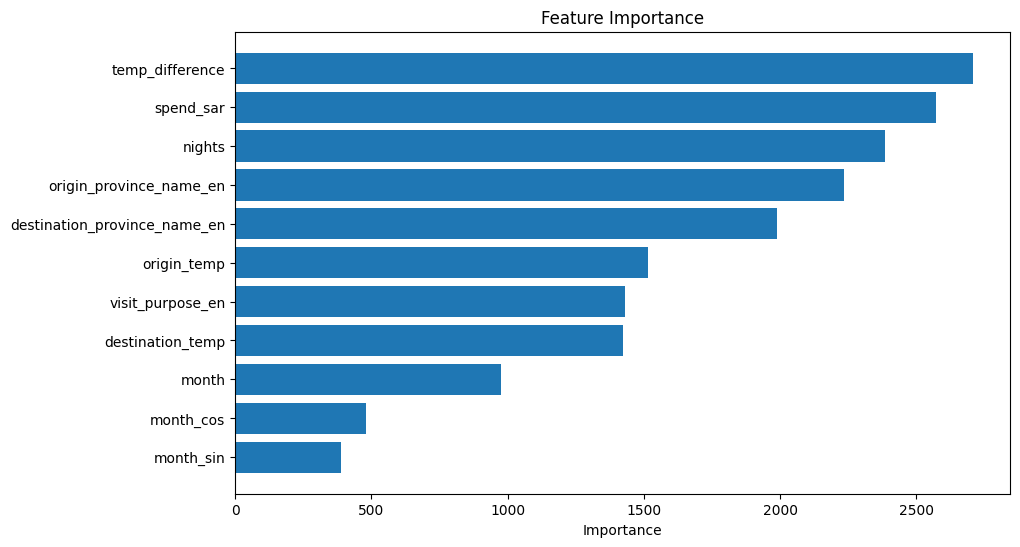

In [ ]:
import numpy as np

feature_importances = model.feature_importances_
sorted_idx = np.argsort(feature_importances)

plt.figure(figsize=(10,6))
plt.barh(np.array(feature_cols)[sorted_idx], feature_importances[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()


In [ ]:
import joblib

joblib.dump(model, 'lightgbm_tourism_model.pkl')
print("✅ Model saved successfully.")


✅ Model saved successfully.
